In [68]:
order_classes = [
    "SNIa", "SNIbc", "SNIIb", "SNII", "SNIIn", "SLSN", 
    "TDE", "Microlensing", "QSO", "AGN", "Blazar", 
    "YSO", "CV/Nova", "LPV", "EA", "EB/EW", 
    "Periodic-Other", "RSCVn", "CEP", "RRLab", "RRLc", "DSCT"
]

class_hierarchy = {
    "Transient": ["SNIa", "SNIbc", "SNIIb", "SNII", "SNIIn", "SLSN", "TDE"],
    "Periodic": [
        "LPV",
        "EA",
        "EB/EW",
        "Periodic-Other",
        "RSCVn",
        "CEP",
        "RRLab",
        "RRLc",
        "DSCT",
    ],
    "Stochastic": [
        "QSO",
        "AGN",
        "Blazar",
        "YSO",
        "CV/Nova",
        "Microlensing",  # ulens get confused with stochastic classes
    ],
}

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def get_confusion_matrix(median_matrix, p5_matrix, p95_matrix, mean_matrices_norm, order_classes, class_hierarchy, path_save=None, figsize=(13, 13), shrink=0.675):
    # Graficando la matriz media
    cmap = plt.cm.Blues
    fig, ax = plt.subplots(figsize=figsize) #, dpi=110)
    #norm = mcolors.Normalize(vmin=0, vmax=np.max(median_matrix))
    #median_matrix = 
    im = ax.imshow(np.around(mean_matrices_norm, decimals=2), interpolation='nearest', cmap=cmap, aspect=.9, vmax=1)#, #norm=norm)

    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, ax=ax, pad=0.02, aspect=40, shrink=shrink)
    cbar.ax.tick_params(labelsize=17)

    # color map
    new_color = cmap(1.0) 

    # Añadiendo manualmente las anotaciones con la media y desviación estándar
    for i in range(median_matrix.shape[0]):
        for j in range(median_matrix.shape[1]):
            mean_val = int(median_matrix[i, j])
            p5_val = int(p5_matrix[i, j])
            p95_val = int(p95_matrix[i, j])

            if mean_matrices_norm[i, j] >= 0.0005:
                text = f'{mean_val}'
                text_p95 = f'+{p95_val}' if p95_val != 0 else ''  # P95 arriba
                text_p5 = f'−{p5_val}' if p5_val != 0 else ''  # P5 abajo

                color = "white" if mean_matrices_norm[i, j] > 0.5 else new_color

                ax.text(j - 0.13, i, text, ha="center", va="center", color=color, fontsize=15.5)
                ax.text(j + 0.018, i - 0.15, text_p95, ha="left", va="bottom", color=color, fontsize=11)
                ax.text(j + 0.018, i + 0.15, text_p5, ha="left", va="top", color=color, fontsize=11)
            else:
                text = f'{mean_val}'
                color = "white" if mean_matrices_norm[i, j] > 0.5 else new_color
                ax.text(j, i, text, ha="center", va="center", color=color, fontsize=12.5)

    # Ajustes finales y mostrar la gráfica
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks(np.arange(len(order_classes)))
    ax.set_yticks(np.arange(len(order_classes)))
    ax.set_xticklabels(order_classes)
    ax.set_yticklabels(order_classes)
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    ax.xaxis.labelpad = 13
    ax.yaxis.labelpad = 13

    for class_list in class_hierarchy.values():
        indices = [order_classes.index(cls) for cls in class_list if cls in order_classes]
        if indices:
            min_idx, max_idx = min(indices), max(indices)
            rect = patches.Rectangle(
                (min_idx - 0.5, min_idx - 0.5),  # Esquina superior izquierda
                max_idx - min_idx + 1,  # Ancho
                max_idx - min_idx + 1,  # Alto
                linewidth=2, edgecolor="black", facecolor='none', clip_on=False
            )
            ax.add_patch(rect)


    ax.set_ylabel('True Label', fontsize=17)
    ax.set_xlabel('Predicted Label', fontsize=17)

    plt.setp(ax.get_xticklabels(), rotation=65, ha='center', va='top', rotation_mode="default")

    if path_save is not None:
        plt.savefig(f"{path_save}", format="pdf", bbox_inches="tight")

    plt.tight_layout()
    plt.show()

In [215]:
import glob

glob.glob('fold_*')

['fold_3',
 'fold_1',
 'fold_4',
 'fold_15',
 'fold_10',
 'fold_0',
 'fold_6',
 'fold_2',
 'fold_7',
 'fold_19',
 'fold_16',
 'fold_17',
 'fold_9',
 'fold_12',
 'fold_14',
 'fold_18',
 'fold_11',
 'fold_5',
 'fold_13',
 'fold_8']

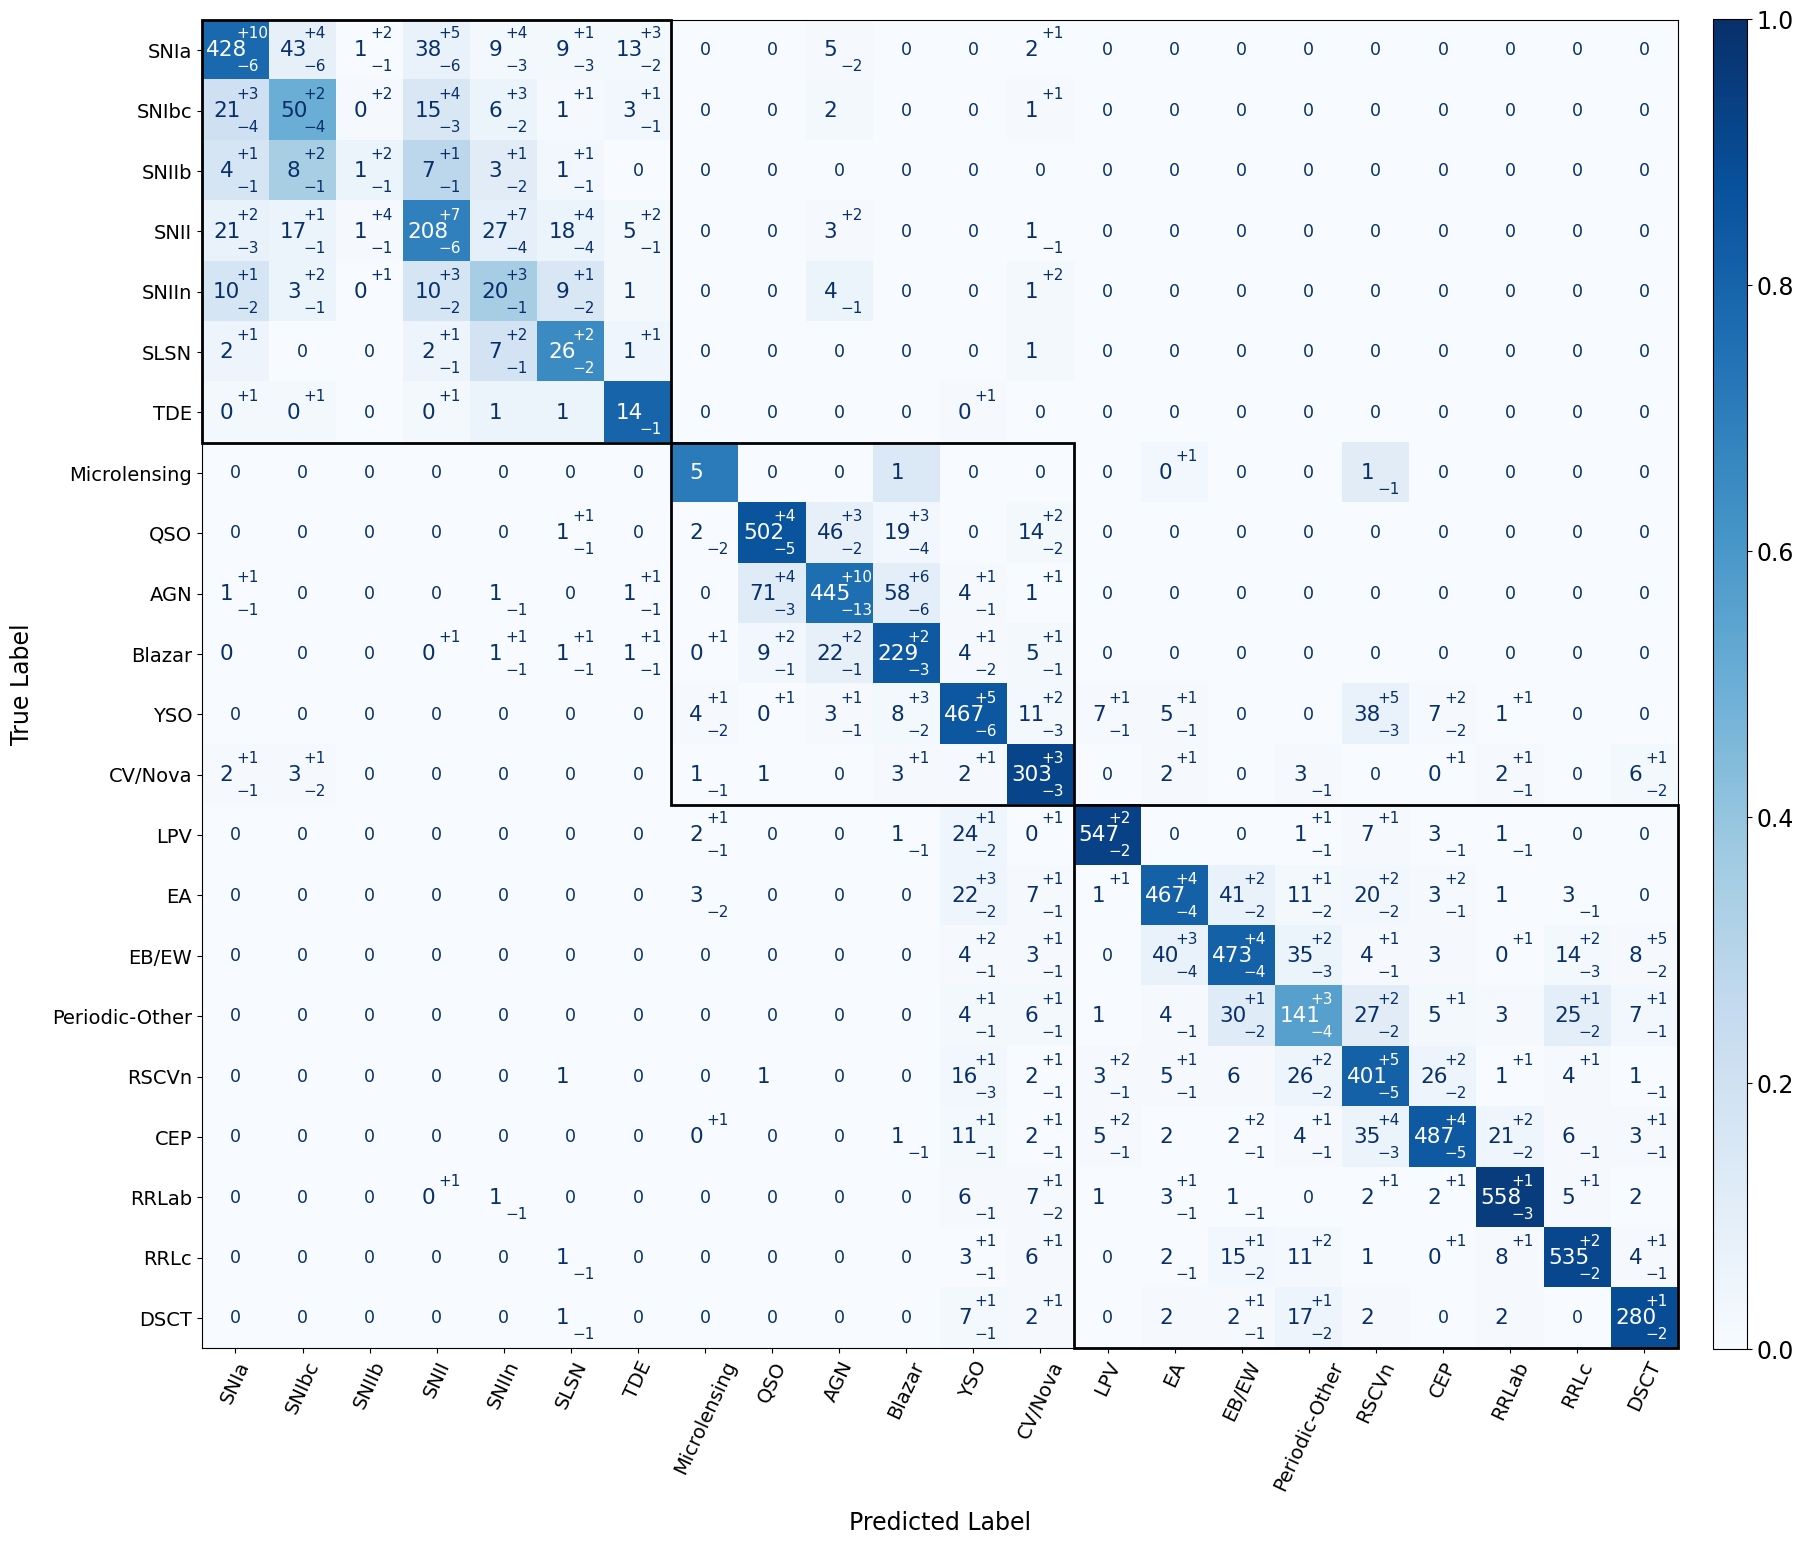

In [243]:
import pandas as pd
from sklearn.metrics import confusion_matrix

matrices = []
matrices_norm = []

num_folds = 20
for fold in range(num_folds):
    df_predictions = pd.read_parquet(f'fold_{fold}/predictions_test.parquet')
    df_predictions = df_predictions[df_predictions['shorten'] == 'None']
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values
    cm = confusion_matrix(y_test, y_pred, labels=order_classes)#, normalize='true')
    cm_norm = confusion_matrix(y_test, y_pred, labels=order_classes, normalize='true')
    matrices.append(cm)
    matrices_norm.append(cm_norm)


# Calculando la media y la desviación estándar
median_matrix = np.median(matrices, axis=0)
p5_matrix = np.abs(median_matrix - np.percentile(matrices, 5, axis=0))
p95_matrix = np.abs(median_matrix - np.percentile(matrices, 95, axis=0)) 
mean_matrices_norm = np.mean(matrices_norm, axis=0)

path_save = 'cm_hbrf_percentiles.pdf'
get_confusion_matrix(median_matrix, p5_matrix, p95_matrix, mean_matrices_norm, order_classes, class_hierarchy, path_save, figsize=(20,20), shrink=0.675)

In [230]:
from sklearn.metrics import classification_report

# Leer las predicciones y calcular los reportes de métricas
num_folds = 20
report_metrics = []

for fold in range(num_folds):
    df_predictions = pd.read_parquet(f'fold_{fold}/predictions_test.parquet')
    df_predictions = df_predictions[df_predictions['shorten'] == 'None']
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values
    report_metrics.append(classification_report(y_test, y_pred, output_dict=True))


# Calcular métricas por clase y macro promedio
data = []
for label in order_classes + ["Macro Avg"]:
    row = [label]
    for metric in ['precision', 'recall', 'f1-score']:
        values = [report_metrics[i_fold][label if label != "Macro Avg" else 'macro avg'][metric] * 100 for i_fold in range(num_folds)]
        row.append(f"{np.mean(values):.2f} ± {np.std(values):.2f}")
    data.append(row)

# Crear DataFrame con las métricas
df = pd.DataFrame(data, columns=["Class", "Precision", "Recall", "F1-score"]).set_index("Class")
df


,Precision,Recall,F1-score
Class,,,
SNIa,87.37 ± 0.57,78.27 ± 0.91,82.56 ± 0.52
SNIbc,40.17 ± 1.65,49.60 ± 2.75,44.37 ± 1.91
SNIIb,34.75 ± 23.20,6.25 ± 3.61,10.21 ± 5.54
SNII,73.95 ± 1.48,68.70 ± 1.48,71.20 ± 0.67
SNIIn,26.67 ± 2.01,35.08 ± 3.04,30.23 ± 1.84
SLSN,38.53 ± 2.23,64.76 ± 4.19,48.26 ± 2.42
TDE,34.51 ± 2.42,80.29 ± 2.81,48.21 ± 2.50
Microlensing,32.19 ± 5.08,71.43 ± 0.00,44.15 ± 4.70
QSO,85.82 ± 0.41,85.98 ± 0.48,85.89 ± 0.26


In [231]:
mapping = {
    "SNIa": "SNIa",
    "SNIbc": "SNIbc",
    "SNIIb": "Others",
    "SNII": "SNII",
    "SNIIn": "SNII",
    "SLSN": "SLSN",
    "TDE": "Others",  # Se ignora
    "Microlensing": "Others",  # Se ignora
    "QSO": "QSO",
    "AGN": "AGN",
    "Blazar": "Blazar",
    "YSO": "YSO",
    "CV/Nova": "CV/Nova",
    "LPV": "LPV",
    "EA": "E",
    "EB/EW": "E",
    "Periodic-Other": "Periodic-Other",
    "RSCVn": "Periodic-Other",
    "CEP": "CEP",
    "RRLab": "RRL",
    "RRLc": "RRL",
    "DSCT": "DSCT"
}

order_classes_sanchez_tax = [
    "SNIa", "SNIbc", "SNII", "SLSN",
    "QSO", "AGN", "Blazar",
    "YSO", "CV/Nova", "LPV", "E",
    "DSCT", "RRL", "CEP", "Periodic-Other", "Others"
    ]

class_hierarchy_sanchez_tax = {
    "Transient": ["SNIa", "SNIbc", "SNII", "SLSN"],
    "Periodic": [
        "LPV",
        "E",
        "Periodic-Other",
        "CEP",
        "RRL",
        "DSCT",
    ],
    "Stochastic": [
        "QSO",
        "AGN",
        "Blazar",
        "YSO",
        "CV/Nova",
    ],
}

In [246]:
14/16

0.875

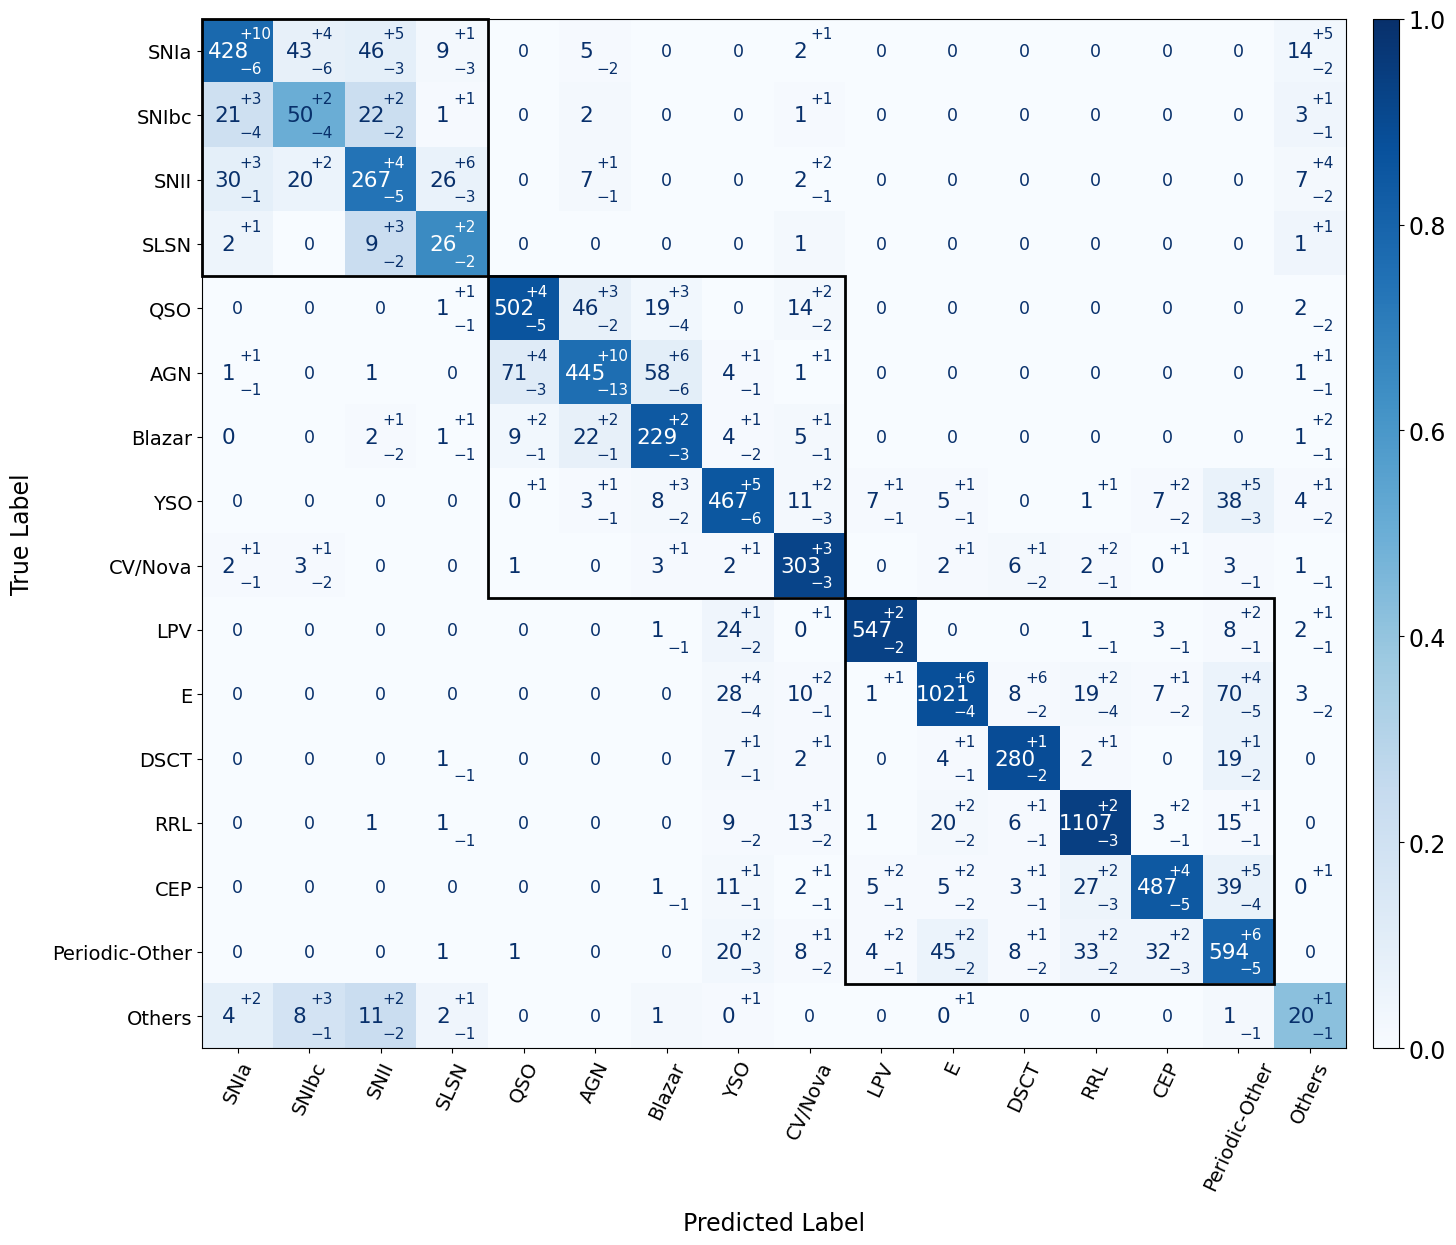

In [250]:
import pandas as pd
from sklearn.metrics import confusion_matrix

matrices = []
matrices_norm = []

num_folds = 20
for fold in range(num_folds):
    df_predictions = pd.read_parquet(f'fold_{fold}/predictions_test.parquet')
    df_predictions = df_predictions[df_predictions['shorten'] == 'None']
    y_test = df_predictions['y_true'].values
    y_pred = df_predictions['y_pred'].values

    y_test_sanchez_tax = [mapping[label] for label in y_test]
    y_pred_sanchez_tax = [mapping[label] for label in y_pred]

    cm = confusion_matrix(y_test_sanchez_tax, y_pred_sanchez_tax, labels=order_classes_sanchez_tax)#, normalize='true')
    matrices.append(cm)

    cm_norm = confusion_matrix(y_test_sanchez_tax, y_pred_sanchez_tax, labels=order_classes_sanchez_tax, normalize='true')
    matrices_norm.append(cm_norm)

# Calculando la media y la desviación estándar
median_matrix = np.median(matrices, axis=0)
p5_matrix = np.abs(median_matrix - np.percentile(matrices, 5, axis=0))
p95_matrix = np.abs(median_matrix - np.percentile(matrices, 95, axis=0)) 
mean_matrices_norm = np.mean(matrices_norm, axis=0)

path_save = 'cm_hbrf_sanchez_tax_nontrain_percentiles.pdf'
get_confusion_matrix(median_matrix, p5_matrix, p95_matrix, mean_matrices_norm, order_classes_sanchez_tax, class_hierarchy_sanchez_tax, path_save, figsize=(16,14), shrink=0.818)

In [251]:
from sklearn.metrics import classification_report

# Leer las predicciones y calcular los reportes de métricas
num_folds = 20
report_metrics = []

for fold in range(num_folds):
    df_predictions = pd.read_parquet(f'fold_{fold}/predictions_test.parquet')
    df_predictions = df_predictions[df_predictions['shorten'] == 'None']
    y_test = [mapping[label] for label in df_predictions['y_true'].values]
    y_pred = [mapping[label] for label in df_predictions['y_pred'].values]
    report_metrics.append(classification_report(y_test, y_pred, output_dict=True))

# Calcular métricas por clase y macro promedio
data = []
for label in order_classes_sanchez_tax + ["Macro Avg"]:
    row = [label]
    for metric in ['precision', 'recall', 'f1-score']:
        values = [report_metrics[i_fold][label if label != "Macro Avg" else 'macro avg'][metric] * 100 for i_fold in range(num_folds)]
        row.append(f"{np.mean(values):.2f} ± {np.std(values):.2f}")
    data.append(row)

# Crear DataFrame con las métricas
df = pd.DataFrame(data, columns=["Class", "Precision", "Recall", "F1-score"]).set_index("Class")
df


,Precision,Recall,F1-score
Class,,,
SNIa,87.37 ± 0.57,78.27 ± 0.91,82.56 ± 0.52
SNIbc,40.17 ± 1.65,49.60 ± 2.75,44.37 ± 1.91
SNII,74.15 ± 0.87,73.65 ± 0.97,73.89 ± 0.53
SLSN,38.53 ± 2.23,64.76 ± 4.19,48.26 ± 2.42
QSO,85.82 ± 0.41,85.98 ± 0.48,85.89 ± 0.26
AGN,83.86 ± 0.43,76.36 ± 1.03,79.93 ± 0.65
Blazar,71.60 ± 1.49,83.79 ± 0.55,77.21 ± 0.97
YSO,81.18 ± 0.97,84.62 ± 0.59,82.86 ± 0.59
CV/Nova,80.64 ± 0.78,92.32 ± 0.63,86.08 ± 0.46
